#Import & functions

In [1]:
pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 4.4 MB/s 
     |████████████████████████████████| 48.3 MB 98 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
pip uninstall opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/config-3.py
    /usr/local/lib/python3.7/dist-packages/cv2/config.py
    /usr/local/lib/python3.7/dist-packages/cv2/cv2.abi3.so
    /usr/local/lib/python3.7/dist-packages/cv2/gapi/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py2.py
    /usr/local/lib/python3.7/dist-packages/cv2/load_config_py3.py
    /usr/local/lib/python3.7/dist-packages/cv2/mat_wrapper/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/misc/version.py
    /usr/local/lib/python3.7/dist-packages/cv2/utils/__init__.py
    /usr/local/lib/python3.7/dist-packages/cv2/version.py
Proceed (y/n)? y
  Successfull

In [3]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 1.2 MB/s 


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import shutil
import itertools
import random
import albumentations as A

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from os import listdir
from os.path import isfile, join
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray
import glob
from numpy import savetxt

In [5]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [6]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocessing

In [8]:
RESIZE = True

#Database
OCT = False
OCTA = True

#Preprocessing
Hist_EQ = False
CLAHE = True
Original = False

# Augmentation
DataAugmentation = True

In [9]:
if OCT:
  img_names = glob.glob('/content/drive/MyDrive/Tesi magistrale/OCTA_3M/OCT(FULL)/*.bmp')
  img_names.sort()
  mask_names = glob.glob('/content/drive/MyDrive/Tesi magistrale/OCTA_3M/GroundTruth/*.bmp')
  mask_names.sort()

elif OCTA:
  img_names = glob.glob('/content/drive/MyDrive/Tesi magistrale/OCTA_3M/OCTA(FULL)/*.bmp')
  img_names.sort()
  mask_names = glob.glob('/content/drive/MyDrive/Tesi magistrale/OCTA_3M/GroundTruth/*.bmp')
  mask_names.sort()


In [10]:
def plot_hist(l):
  plt.figure(figsize=(7, 4))
  plt.hist(l.flat, bins=100, range=(0,255))
  plt.show()

In [11]:
root_originals_sub = img_names
original = []
equalized = []
clahed = []

i = 0
for path_original in root_originals_sub:
  i = i + 1
  img = cv2.imread(path_original,1)

  if RESIZE:
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_CUBIC)
    
  lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l, a, b, = cv2.split(lab_img)

  #plot_hist(l)

  equ = cv2.equalizeHist(l)

  #plot_hist(equ)

  updated_lab_img = cv2.merge((equ, a, b))
  hist_eq_img = cv2.cvtColor(updated_lab_img, cv2.COLOR_LAB2BGR)

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  clahe_img = clahe.apply(l)

  #plot_hist(clahe_img)

  updated_lab_img2 = cv2.merge((clahe_img, a, b))
  CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  hist_eq_img = cv2.cvtColor(hist_eq_img, cv2.COLOR_BGR2RGB)
  CLAHE_img = cv2.cvtColor(CLAHE_img, cv2.COLOR_BGR2RGB)

  original.append(img[:,:,0])
  equalized.append(hist_eq_img[:,:,0])
  clahed.append(CLAHE_img[:,:,0])

original_dataset = np.array(original)
equalized_dataset = np.array(equalized)
clahed_dataset = np.array(clahed)
original_dataset = np.expand_dims(original_dataset, axis=3)
equalized_dataset = np.expand_dims(equalized_dataset, axis=3)
clahed_dataset = np.expand_dims(clahed_dataset, axis=3)

In [12]:
print(original_dataset.shape)

(200, 256, 256, 1)


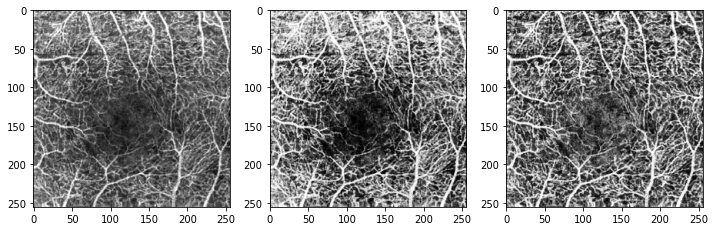

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(original_dataset[10,:,:,0],cmap='gray')
plt.subplot(132)
plt.imshow(equalized_dataset[10,:,:,0],cmap='gray')
plt.subplot(133)
plt.imshow(clahed_dataset[10,:,:,0],cmap='gray')

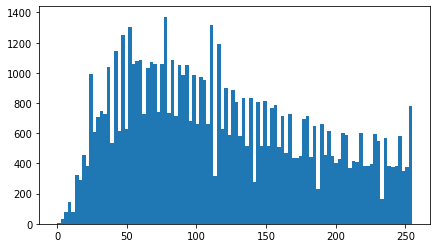

In [14]:
plot_hist(clahed_dataset[10,:,:,0])

In [15]:
segmentation = []
for path_segmentation in mask_names:
  img = cv2.imread(path_segmentation,0)
  if RESIZE:
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_CUBIC)
  (thresh, blackAndWhiteImg) = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
  segmentation.append(blackAndWhiteImg)

segm_dataset = np.array(segmentation)
segm_dataset = np.expand_dims(segm_dataset, axis=3)

In [16]:
clahed_dataset = clahed_dataset/255.
equalized_dataset = equalized_dataset/255.
original_dataset = original_dataset/255.
segm_dataset = segm_dataset/255.

In [17]:
from sklearn.model_selection import train_test_split
if Hist_EQ:
  X_train, X_test, y_train, y_test = train_test_split(equalized_dataset, segm_dataset, test_size = 0.10, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 42)
elif CLAHE:
  X_train, X_test, y_train, y_test = train_test_split(clahed_dataset, segm_dataset, test_size = 0.10, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 42)
elif Original:
  X_train, X_test, y_train, y_test = train_test_split(original_dataset, segm_dataset, test_size = 0.10, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 42)

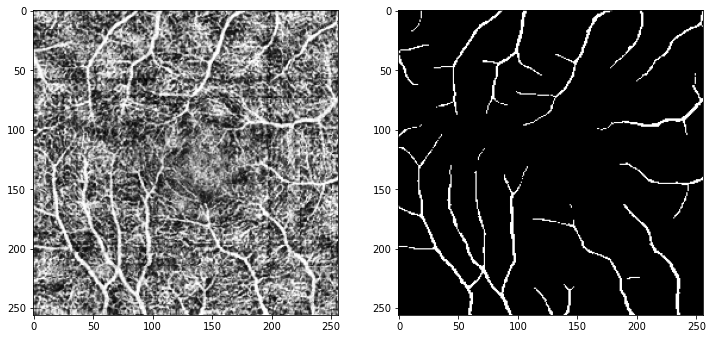

In [18]:
#Sanity check, view few mages
import random

#image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[10,:,:,0],cmap = 'gray')
plt.subplot(122)
plt.imshow(y_train[10,:,:,0],cmap = 'gray')
plt.show()

#Data Augmentation

In [33]:
if DataAugmentation:
  X_train_augm = []
  y_train_augm = []
  original_height = len(X_train[0])
  original_width = len(X_train[0])

  for i in range(len(X_train)):
  #for i in range(1):
    image = X_train[i,:,:,:]
    mask = y_train[i,:,:,:]
    X_train_augm.append(X_train[i])
    y_train_augm.append(y_train[i])

  # 1 Horizontal Flip 
    aug = A.HorizontalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_center_cropped = augmented['image']
    mask_center_cropped = augmented['mask']
    X_train_augm.append(image_center_cropped )
    y_train_augm.append(mask_center_cropped)

  # 2 Vertical Flip
    aug = A.VerticalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_v_flipped = augmented['image']
    mask_v_flipped = augmented['mask']
    X_train_augm.append(image_v_flipped)
    y_train_augm.append(mask_v_flipped)

    '''
  # 3 Random Rotate 90
    aug = A.RandomRotate90(p=1)
    augmented = aug(image=image, mask=mask)
    image_rot90 = augmented['image']
    mask_rot90 = augmented['mask']
    X_train_augm.append(image_rot90)
    y_train_augm.append(mask_rot90)
    '''

  # 4 Transpose 
    aug = A.Transpose(p=1)
    augmented = aug(image=image, mask=mask)
    image_transposed = augmented['image']
    mask_transposed = augmented['mask']
    X_train_augm.append(image_transposed)
    y_train_augm.append(mask_transposed)

  ############################################################################
  # NON-RIGID TRANSFORMATION

  # 5 Elastic Transformation
    aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
    random.seed(7)
    augmented = aug(image=image, mask=mask)
    image_elastic = augmented['image']
    mask_elastic = augmented['mask']
    X_train_augm.append(image_elastic)
    y_train_augm.append(mask_elastic)

  # 6 Grid Distortion
    aug = A.GridDistortion(p=1)
    random.seed(7)
    augmented = aug(image=image, mask=mask)
    image_grid = augmented['image']
    mask_grid = augmented['mask']
    X_train_augm.append(image_grid)
    y_train_augm.append(mask_grid)
    '''
  # 7 Optical Distortion
    aug = A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)
    random.seed(7)
    augmented = aug(image=image, mask=mask)
    image_optical = augmented['image']
    mask_optical = augmented['mask']
    X_train_augm.append(image_optical)
    y_train_augm.append(mask_optical)
    '''
  ##############################################################################
  # COMPOSE
    '''
  # 8 Non spatial transformations
    aug = A.Compose([
        A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
            ], p=0.8),
        #A.RandomBrightnessContrast(p=0.8),    
        A.RandomGamma(p=0.8)])
    random.seed(11)
    augmented = aug(image=image, mask=mask)
    image_heavy = augmented['image']
    mask_heavy = augmented['mask']
    X_train_augm.append(image_heavy)
    y_train_augm.append(mask_heavy)
    '''
  ##############################################################################
  # PIXEL TRANSFORMATION
    '''
  # 9 Pixel transformation
    aug = A.RandomContrast(limit=1.0, p=1)
    random.seed(11)
    augmented = aug(image=image, mask=mask)
    image_contrast = augmented['image']
    mask_contrast = augmented['mask']
    X_train_augm.append(image_contrast)
    y_train_augm.append(mask_contrast)
    '''
  # 10 Pixel transformation
    aug = A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=1)
    random.seed(11)
    augmented = aug(image=image, mask=mask)
    image_blur = augmented['image']
    mask_blur = augmented['mask']
    X_train_augm.append(image_blur)
    y_train_augm.append(mask_blur)

  # 11 Pixel transformation
    aug = A.Compose([
        A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=1),              
        A.RandomContrast(limit=1.0, p=1)])
    #aug = A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=1)
    random.seed(11)
    augmented = aug(image=image, mask=mask)
    image_sharpenContr = augmented['image']
    mask_sharpenContr = augmented['mask']
    X_train_augm.append(image_sharpenContr)
    y_train_augm.append(mask_sharpenContr)
    

  X_train_augm = np.array(X_train_augm)
  y_train_augm = np.array(y_train_augm)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1641: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [34]:
y_train_augm.shape

(1296, 256, 256, 1)

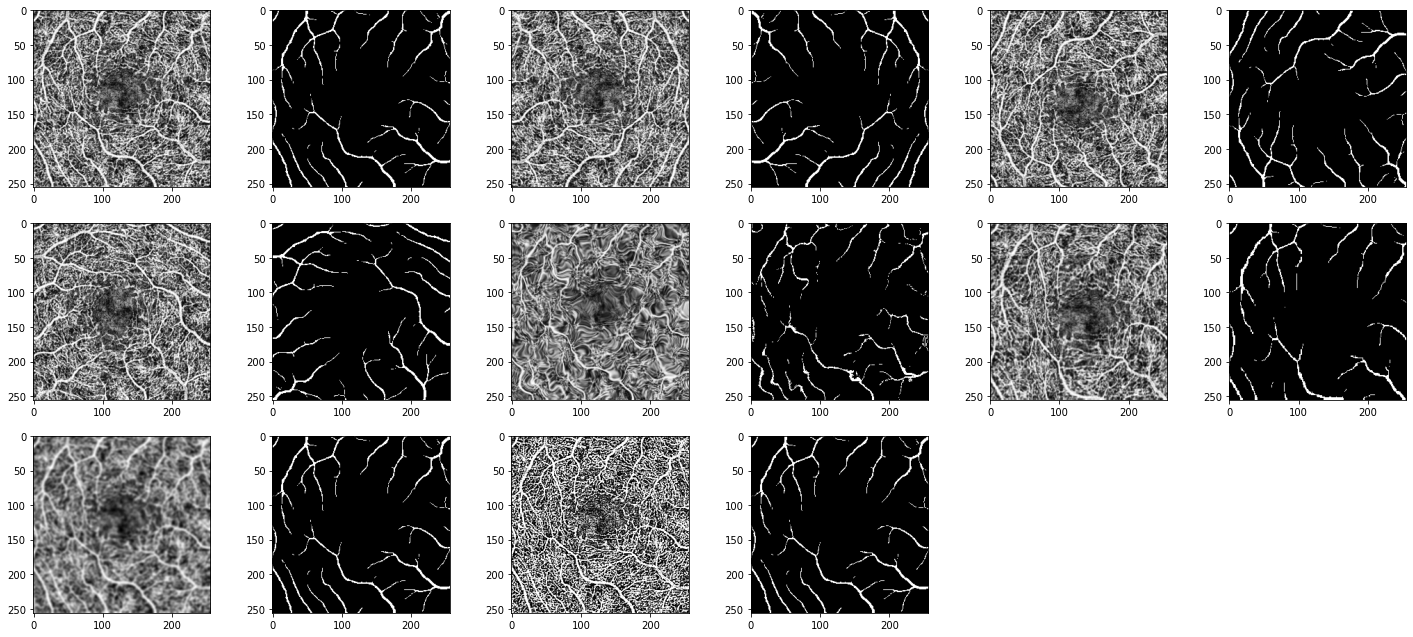

In [35]:
plt.figure(figsize=(25, 15))
plt.subplot(461)
plt.imshow(X_train_augm[0,:,:,0],cmap = 'gray')
plt.subplot(462)
plt.imshow(y_train_augm[0,:,:,0],cmap = 'gray')
plt.subplot(463)
plt.imshow(X_train_augm[1,:,:,0],cmap = 'gray')
plt.subplot(464)
plt.imshow(y_train_augm[1,:,:,0],cmap = 'gray')
plt.subplot(465)
plt.imshow(X_train_augm[2,:,:,0],cmap = 'gray')
plt.subplot(466)
plt.imshow(y_train_augm[2,:,:,0],cmap = 'gray')
plt.subplot(467)
plt.imshow(X_train_augm[3,:,:,0],cmap = 'gray')
plt.subplot(468)
plt.imshow(y_train_augm[3,:,:,0],cmap = 'gray')
plt.subplot(469)
plt.imshow(X_train_augm[4,:,:,0],cmap = 'gray')
plt.subplot(4,6,10)
plt.imshow(y_train_augm[4,:,:,0],cmap = 'gray')
plt.subplot(4,6,11)
plt.imshow(X_train_augm[5,:,:,0],cmap = 'gray')
plt.subplot(4,6,12)
plt.imshow(y_train_augm[5,:,:,0],cmap = 'gray')
plt.subplot(4,6,13)
plt.imshow(X_train_augm[6,:,:,0],cmap = 'gray')
plt.subplot(4,6,14)
plt.imshow(y_train_augm[6,:,:,0],cmap = 'gray')
plt.subplot(4,6,15)
plt.imshow(X_train_augm[7,:,:,0],cmap = 'gray')
plt.subplot(4,6,16)
plt.imshow(y_train_augm[7,:,:,0],cmap = 'gray')
plt.show()

In [36]:
np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_augmented_partial.npy',X_train_augm)
np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train_augmented_partial.npy',y_train_augm)
np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_augmented_partial.npy',X_test)
np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test_augmented_partial.npy',y_test)
np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/X_val_augmented_partial.npy',X_val)
np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/y_val_augmented_partial.npy',y_val)

In [ ]:
#np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/X_train_OCTA_CLAHE.npy',X_train)
#np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/X_test_OCTA_CLAHE.npy',X_test)
#np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/y_train_EQ.npy',y_train)
#np.save('/content/drive/MyDrive/Tesi magistrale/Numpy/y_test_EQ.npy',y_test)